In [7]:
import torch
import stable_baselines3
import sys
import numpy as np

print("python version:", sys.version)
print("stable_baselines3 version:", stable_baselines3.__version__)
print("torch version:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda version:", torch.version.cuda)
print("cudnn version:", torch.backends.cudnn.version())

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# set torch default device
torch.set_default_device(device)

python version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
stable_baselines3 version: 2.3.2
torch version: 2.4.0+cu121
cuda available: True
cuda version: 12.1
cudnn version: 90100
device: cuda


In [8]:
# import cv2

# # show image
# cv2.namedWindow("image", cv2.WINDOW_NORMAL)
# cv2.imshow("image", np.zeros((100, 100)))

# Equation of Motion 3D Quadcopter

In [1]:
# reload sympy
from sympy import *

# Equations of motion 3D quadcopter from https://arxiv.org/pdf/2304.13460.pdf

# w1,w2,w3,w4 are the motor speeds normalized to [-1,1]
# u1,u2,u3,u4 are the motor commands normalized to [-1,1]

state = symbols('x y z v_x v_y v_z phi theta psi p q r w1 w2 w3 w4')
x,y,z,vx,vy,vz,phi,theta,psi,p,q,r,w1,w2,w3,w4 = state
control = symbols('U_1 U_2 U_3 U_4')    # normalized motor commands between [-1,1]
u1,u2,u3,u4 = control

# parameters based on fit from flight_data/aggressive_cmds2.csv
g = 9.81
params = symbols('k_x, k_y, k_w, k_p1, k_p2, k_p3, k_p4, k_q1, k_q2, k_q3, k_q4, k_r1, k_r2, k_r3, k_r4, k_r5, k_r6, k_r7, k_r8, tau, k, w_min, w_max')
k_x, k_y, k_w, k_p1, k_p2, k_p3, k_p4, k_q1, k_q2, k_q3, k_q4, k_r1, k_r2, k_r3, k_r4, k_r5, k_r6, k_r7, k_r8, tau, k, w_min, w_max = params

# Rotation matrix 
Rx = Matrix([[1, 0, 0], [0, cos(phi), -sin(phi)], [0, sin(phi), cos(phi)]])
Ry = Matrix([[cos(theta), 0, sin(theta)], [0, 1, 0], [-sin(theta), 0, cos(theta)]])
Rz = Matrix([[cos(psi), -sin(psi), 0], [sin(psi), cos(psi), 0], [0, 0, 1]])
R = Rz*Ry*Rx

# Body velocity
vbx, vby, vbz = R.T@Matrix([vx,vy,vz])

# normalized motor speeds to rad/s
w_min_n = 0.
w_max_n = 3000.
W1 = (w1+1)/2*(w_max_n-w_min_n) + w_min_n
W2 = (w2+1)/2*(w_max_n-w_min_n) + w_min_n
W3 = (w3+1)/2*(w_max_n-w_min_n) + w_min_n
W4 = (w4+1)/2*(w_max_n-w_min_n) + w_min_n

# motor commands scaled to [0,1]
U1 = (u1+1)/2
U2 = (u2+1)/2
U3 = (u3+1)/2
U4 = (u4+1)/2

# first order delay:
# the steadystate rpm motor response to the motor command U is described by:
# Wc = (w_max-w_min)*sqrt(k U**2 + (1-k)*U) + w_min
Wc1 = (w_max-w_min)*sqrt(k*U1**2 + (1-k)*U1) + w_min
Wc2 = (w_max-w_min)*sqrt(k*U2**2 + (1-k)*U2) + w_min
Wc3 = (w_max-w_min)*sqrt(k*U3**2 + (1-k)*U3) + w_min
Wc4 = (w_max-w_min)*sqrt(k*U4**2 + (1-k)*U4) + w_min

# rad/s
d_W1 = (Wc1 - W1)/tau
d_W2 = (Wc2 - W2)/tau
d_W3 = (Wc3 - W3)/tau
d_W4 = (Wc4 - W4)/tau

# normalized motor speeds d/dt[W - w_min_n)/(w_max_n-w_min_n)*2 - 1]
d_w1 = d_W1/(w_max_n-w_min_n)*2
d_w2 = d_W2/(w_max_n-w_min_n)*2
d_w3 = d_W3/(w_max_n-w_min_n)*2
d_w4 = d_W4/(w_max_n-w_min_n)*2

# Thrust and Drag
T = -k_w*(W1**2 + W2**2 + W3**2 + W4**2)
Dx = -k_x*vbx*(W1+W2+W3+W4)
Dy = -k_y*vby*(W1+W2+W3+W4)

# Moments
# Mx = k_p*(-W1**2-W2**2+W3**2+W4**2)
# My = k_q1*(W1**2+W3**2) + k_q2*(W2**2+W4**2)
# Mz = k_r1*(-W1+W2+W3-W4) + k_r2*(-d_W1+d_W2-d_W3+d_W4)

Mx = -k_p1*W1**2 - k_p2*W2**2 + k_p3*W3**2 + k_p4*W4**2
My = -k_q1*W1**2 + k_q2*W2**2 - k_q3*W3**2 + k_q4*W4**2
Mz = -k_r1*W1 + k_r2*W2 + k_r3*W3 - k_r4*W4 - k_r5*d_W1 + k_r6*d_W1 + k_r7*d_W1 - k_r8*d_W1

# Dynamics
d_x = vx
d_y = vy
d_z = vz

d_vx, d_vy, d_vz = Matrix([0,0,g]) + R@Matrix([Dx, Dy,T])

d_phi   = p + q*sin(phi)*tan(theta) + r*cos(phi)*tan(theta)
d_theta = q*cos(phi) - r*sin(phi)
d_psi   = q*sin(phi)/cos(theta) + r*cos(phi)/cos(theta)

d_p     = Mx
d_q     = My
d_r     = Mz

# State space model
f = [d_x, d_y, d_z, d_vx, d_vy, d_vz, d_phi, d_theta, d_psi, d_p, d_q, d_r, d_w1, d_w2, d_w3, d_w4]

# lambdify
f_func = lambdify((Array(state), Array(control), Array(params)), Array(f), 'numpy')

# extra functions
# get_body_velocity = lambdify((Array(state),), Array([vbx, vby, vbz]), 'numpy')

In [4]:
for p in params:
    print(p.name)

k_x
k_y
k_w
k_p1
k_p2
k_p3
k_p4
k_q1
k_q2
k_q3
k_q4
k_r1
k_r2
k_r3
k_r4
k_r5
k_r6
k_r7
k_r8
tau
k
w_min
w_max


In [10]:
# Robin:
params = {
'k_w': -2.49e-06, 'k_x': -4.85e-05, 'k_y': -7.28e-05,
'k_p1': -6.55e-05, 'k_p2': -6.61e-05, 'k_p3': 6.36e-05, 'k_p4': 6.67e-05,
'k_q1': -5.28e-05, 'k_q2': 5.86e-05, 'k_q3': -5.05e-05, 'k_q4': 5.89e-05,
'k_r1': 1.07e-02, 'k_r2': 1.07e-02, 'k_r3': 1.07e-02, 'k_r4': 1.07e-02, 'k_r5': 1.97e-03, 'k_r6': 1.97e-03, 'k_r7': 1.97e-03, 'k_r8': 1.97e-03,
'w_min': 238.49, 'w_max': 3295.50, 'k': 0.95, 'tau': 0.04
}
param_ranges_robin = {key: [abs(value), abs(value)] for key, value in params.items()}

# Till:
params = {
'k_w': -6.00e-07, 'k_x': 0*-3.36e-05, 'k_y': 0*-3.73e-05,
'k_p1': -2.57e-05, 'k_p2': -2.51e-05, 'k_p3': 2.72e-05, 'k_p4': 2.00e-05,
'k_q1': -9.10e-06, 'k_q2': 9.96e-06, 'k_q3': -1.17e-05, 'k_q4': 8.21e-06,
'k_r1': 9.64e-03, 'k_r2': 9.64e-03, 'k_r3': 9.64e-03, 'k_r4': 9.64e-03, 'k_r5': 1.14e-03, 'k_r6': 1.14e-03, 'k_r7': 1.14e-03, 'k_r8': 1.14e-03,
'w_min': 305.40, 'w_max': 4887.57, 'k': 0.84, 'tau': 0.04
}
param_ranges_till = {key: [abs(value), abs(value)] for key, value in params.items()}

#-----------------------------------------------------------------------------------------
# Robin normalized:
params_normalized = {
'k_w': -2.71e+01, 'k_x': -1.60e-01, 'k_y': -2.40e-01,
'k_p1': -7.11e+02, 'k_p2': -7.18e+02, 'k_p3': 6.91e+02, 'k_p4': 7.24e+02,
'k_q1': -5.73e+02, 'k_q2': 6.37e+02, 'k_q3': -5.48e+02, 'k_q4': 6.40e+02,
'k_r': 3.52e+01, 'k_rd': 6.49e+00,
'w_min': 238.49, 'w_max': 3295.50, 'k': 0.95, 'tau': 0.04
}

# Till normalized:
params_normalized = {
'k_w': -1.43e+01, 'k_x': -1.64e-01, 'k_y': -1.82e-01,
'k_p1': -6.15e+02, 'k_p2': -5.98e+02, 'k_p3': 6.50e+02, 'k_p4': 4.79e+02,
'k_q1': -2.17e+02, 'k_q2': 2.38e+02, 'k_q3': -2.80e+02, 'k_q4': 1.96e+02,
'k_r': 4.71e+01, 'k_rd': 5.57e+00,
'w_min': 305.40, 'w_max': 4887.57, 'k': 0.84, 'tau': 0.04
}
#-----------------------------------------------------------------------------------------

def randomization(num):
    # returns randomized parameters based on robin and till's values
    
    # actuator model
    w_min   = np.random.uniform(0,   500, size=num)
    w_max   = np.random.uniform(3000,5000, size=num)
    k       = np.random.uniform(0., 1.0, size=num)
    tau     = np.random.uniform(0.01, 0.1, size=num)
    
    # thrust and drag
    k_wn    = np.random.uniform(1.0e+01, 3.0e+01, size=num)
    k_xn    = np.random.uniform(1.0e-01, 3.0e-01, size=num)
    k_yn    = np.random.uniform(1.0e-01, 3.0e-01, size=num)
    
    # moments parameters nominal
    k_pn    = np.random.uniform(2.0e+02, 8.0e+02, size=num)
    k_qn    = np.random.uniform(2.0e+02, 8.0e+02, size=num)
    k_rn    = np.random.uniform(2.0e+01, 8.0e+01, size=num)
    k_rdn   = np.random.uniform(2.0e+00, 8.0e+00, size=num)
    
    # moments parameters variation per motor
    k_p1n   = k_pn + np.random.uniform(-5.0e+01, 5.0e+01, size=num)
    k_p2n   = k_pn + np.random.uniform(-5.0e+01, 5.0e+01, size=num)
    k_p3n   = k_pn + np.random.uniform(-5.0e+01, 5.0e+01, size=num)
    k_p4n   = k_pn + np.random.uniform(-5.0e+01, 5.0e+01, size=num)
    
    k_q1n   = k_qn + np.random.uniform(-5.0e+01, 5.0e+01, size=num)
    k_q2n   = k_qn + np.random.uniform(-5.0e+01, 5.0e+01, size=num)
    k_q3n   = k_qn + np.random.uniform(-5.0e+01, 5.0e+01, size=num)
    k_q4n   = k_qn + np.random.uniform(-5.0e+01, 5.0e+01, size=num)
    
    k_r1n   = k_rn #+ np.random.uniform(1.0e+01, 9.0e+01, size=num)
    k_r2n   = k_rn #+ np.random.uniform(1.0e+01, 9.0e+01, size=num)
    k_r3n   = k_rn #+ np.random.uniform(1.0e+01, 9.0e+01, size=num)
    k_r4n   = k_rn #+ np.random.uniform(1.0e+01, 9.0e+01, size=num)
    
    k_r5n   = k_rdn #+ np.random.uniform(-5.0e-01, 5.0e-01, size=num)
    k_r6n   = k_rdn #+ np.random.uniform(-5.0e-01, 5.0e-01, size=num)
    k_r7n   = k_rdn #+ np.random.uniform(-5.0e-01, 5.0e-01, size=num)
    k_r8n   = k_rdn #+ np.random.uniform(-5.0e-01, 5.0e-01, size=num)
    
    # non-normalized parameters
    k_w     = k_wn/(w_max**2)
    k_x     = k_xn/(w_max)
    k_y     = k_yn/(w_max)
    
    k_p1    = k_p1n/(w_max**2)
    k_p2    = k_p2n/(w_max**2)
    k_p3    = k_p3n/(w_max**2)
    k_p4    = k_p4n/(w_max**2)
    
    k_q1    = k_q1n/(w_max**2)
    k_q2    = k_q2n/(w_max**2)
    k_q3    = k_q3n/(w_max**2)
    k_q4    = k_q4n/(w_max**2)
    
    k_r1    = k_r1n/(w_max)
    k_r2    = k_r2n/(w_max)
    k_r3    = k_r3n/(w_max)
    k_r4    = k_r4n/(w_max)
    
    k_r5    = k_r5n/(w_max)
    k_r6    = k_r6n/(w_max)
    k_r7    = k_r7n/(w_max)
    k_r8    = k_r8n/(w_max)
    
    # keys = ['k_x', 'k_y', 'k_w', 'k_p1', 'k_p2', 'k_p3', 'k_p4', 'k_q1', 'k_q2', 'k_q3', 'k_q4', 'k_r1', 'k_r2', 'k_r3', 'k_r4', 'k_r5', 'k_r6', 'k_r7', 'k_r8', 'tau', 'k', 'w_min', 'w_max']
    values = [k_x, k_y, k_w, k_p1, k_p2, k_p3, k_p4, k_q1, k_q2, k_q3, k_q4, k_r1, k_r2, k_r3, k_r4, k_r5, k_r6, k_r7, k_r8, tau, k, w_min, w_max]
    
    # print with 2 significant digits
    # for key, value in zip(keys, values):
    #     print(f"{key}: ", end='')
    #     for i in range(num):
    #         print(f"{value[i]:.2e}, ", end='')
    #     print()
    
    # return array
    out = np.stack(values, axis=1)
    return out  
    

In [11]:
param_values = {
    # thrust, drag:
    'k_x': 6.24e-05,
    'k_y': 6.96e-05,
    'k_w': 2.47e-06,
    # roll moment:
    'k_p1': 6.54e-05,
    'k_p2': 6.49e-05,
    'k_p3': 6.15e-05,
    'k_p4': 6.51e-05,
    # pitch moment:
    'k_q1': 5.44e-05,
    'k_q2': 5.74e-05,
    'k_q3': 5.05e-05,
    'k_q4': 5.73e-05,
    # yaw moment:
    'k_r1': 1.39e-02,
    'k_r2': 1.12e-02,
    'k_r3': 1.06e-02,
    'k_r4': 9.08e-03,
    # yaw moment derivative term:
    'k_r5': 2.47e-03,
    'k_r6': 2.41e-03,
    'k_r7': 2.42e-03,
    'k_r8': 2.45e-03,
    # actuator model
    'tau': 0.04,
    'k': 0.98,
    'w_min': 260.34,
    'w_max': 3365.29    
}
    

param_ranges = {
    # thrust, drag:
    'k_x': [5.0e-05, 7.0e-05],
    'k_y': [5.0e-05, 7.0e-05],
    'k_w': [2.0e-06, 3.0e-06],
    # roll moment:
    'k_p1': [6.0e-05, 7.0e-05],
    'k_p2': [6.0e-05, 7.0e-05],
    'k_p3': [6.0e-05, 7.0e-05],
    'k_p4': [6.0e-05, 7.0e-05],
    # pitch moment:
    'k_q1': [5.0e-05, 6.0e-05],
    'k_q2': [5.0e-05, 6.0e-05],
    'k_q3': [5.0e-05, 6.0e-05],
    'k_q4': [5.0e-05, 6.0e-05],
    # yaw moment:
    'k_r1': [9.0e-03, 1.4e-02],
    'k_r2': [9.0e-03, 1.4e-02],
    'k_r3': [9.0e-03, 1.4e-02],
    'k_r4': [9.0e-03, 1.4e-02],
    # yaw moment derivative term:
    'k_r5': [2.3e-03, 2.5e-03],
    'k_r6': [2.3e-03, 2.5e-03],
    'k_r7': [2.3e-03, 2.5e-03],
    'k_r8': [2.3e-03, 2.5e-03],
    # actuator model
    'tau': [0.01, 0.1],
    'k': [0., 1.0],
    'w_min': [100, 500],
    'w_max': [2500, 3500]
}


param_ranges_fixed = {key: [value, value] for key, value in param_values.items()}

# Define the 3D Quad Gates Environment

In [12]:
# Efficient vectorized version of the environment
from gymnasium import spaces
from stable_baselines3.common.vec_env import VecEnv

class Quadcopter3DGates(VecEnv):
    def __init__(self,
                 num_envs,
                 gates_pos,
                 gate_yaw,
                 start_pos,
                 gates_ahead=0,
                 pause_if_collision=False,
                 param_ranges = param_ranges,
                 motor_limit=1.0,
                 randomization_test=True
                 ):
        
        # Define the race track
        self.start_pos = start_pos.astype(np.float32)
        self.gate_pos = gates_pos.astype(np.float32)
        self.gate_yaw = gate_yaw.astype(np.float32)
        self.num_gates = gates_pos.shape[0]
        self.gates_ahead = gates_ahead
        
        # Pause if collision
        self.pause_if_collision = pause_if_collision
        
        # Domain randomization
        self.param_ranges = param_ranges
        self.params = np.array([np.random.uniform(low=param_ranges[p][0], high=param_ranges[p][1], size=(num_envs)) for p in param_ranges]).T
        self.randomization_test = randomization_test
        
        # Motor limit
        self.motor_limit = motor_limit

        # Calculate relative gates
        # pos,yaw of gate i in reference frame of gate i-1 (assumes a looped track)
        self.gate_pos_rel = np.zeros((self.num_gates,3), dtype=np.float32)
        self.gate_yaw_rel = np.zeros(self.num_gates, dtype=np.float32)
        for i in range(0,self.num_gates):
            self.gate_pos_rel[i] = self.gate_pos[i] - self.gate_pos[i-1]
            # Rotation matrix
            R = np.array([
                [np.cos(self.gate_yaw[i-1]), np.sin(self.gate_yaw[i-1])],
                [-np.sin(self.gate_yaw[i-1]), np.cos(self.gate_yaw[i-1])]
            ])
            self.gate_pos_rel[i,0:2] = R@self.gate_pos_rel[i,0:2]
            self.gate_yaw_rel[i] = self.gate_yaw[i] - self.gate_yaw[i-1]
            # wrap yaw
            self.gate_yaw_rel[i] %= 2*np.pi
            if self.gate_yaw_rel[i] > np.pi:
                self.gate_yaw_rel[i] -= 2*np.pi
            elif self.gate_yaw_rel[i] < -np.pi:
                self.gate_yaw_rel[i] += 2*np.pi

        # Define the target gate for each environment
        self.target_gates = np.zeros(num_envs, dtype=int)

        # action space: [cmd1, cmd2, cmd3, cmd4]
        # U = (u+1)/2 --> u = 2U-1
        u_lim = 2*self.motor_limit-1
        action_space = spaces.Box(low=-1, high=u_lim, shape=(4,))

        # observation space: pos[G], vel[G], att[eulerB->G], rates[B], rpms, future_gates[G], future_gate_dirs[G]
        # [G] = reference frame aligned with target gate
        # [B] = body frame
        self.state_len = 16+4*self.gates_ahead
        self.input_hist = 1
        observation_space = spaces.Box(
            low  = np.array([-np.inf]*self.state_len*self.input_hist),
            high = np.array([ np.inf]*self.state_len*self.input_hist)
        )

        # Initialize the VecEnv
        VecEnv.__init__(self, num_envs, observation_space, action_space)

        # world state: pos[W], vel[W], att[eulerB->W], rates[B], rpms
        self.world_states = np.zeros((num_envs,16), dtype=np.float32)
        # observation state
        self.states = np.zeros((num_envs,self.state_len*self.input_hist), dtype=np.float32)
        # state history tracking
        num_hist = 10
        self.state_hist = np.zeros((num_envs,num_hist,self.state_len), dtype=np.float32)

        # Define any other environment-specific parameters
        self.max_steps = 1200      # Maximum number of steps in an episode
        self.dt = np.float32(0.01) # Time step duration

        self.step_counts = np.zeros(num_envs, dtype=int)
        self.actions = np.zeros((num_envs,4), dtype=np.float32)
        self.prev_actions = np.zeros((num_envs,4), dtype=np.float32)
        self.dones = np.zeros(num_envs, dtype=bool)
        self.final_gate_passed = np.zeros(num_envs, dtype=bool)

        self.update_states = self.update_states_gate
        
        self.pause = False

    def update_states_gate(self):
        # Transform pos and vel in gate frame
        gate_pos = self.gate_pos[self.target_gates%self.num_gates]
        gate_yaw = self.gate_yaw[self.target_gates%self.num_gates]

        # Rotation matrix from world frame to gate frame
        R = np.array([
            [np.cos(gate_yaw), np.sin(gate_yaw)],
            [-np.sin(gate_yaw), np.cos(gate_yaw)]
        ]).transpose((2,1,0))

        # new state array to prevent the weird bug related to indexing ([:] syntax)
        new_states = np.zeros((self.num_envs,self.state_len), dtype=np.float32)

        # Update positions
        pos_W = self.world_states[:,0:3]
        pos_G = (pos_W[:,np.newaxis,0:2] - gate_pos[:,np.newaxis,0:2]) @ R
        new_states[:,0:2] = pos_G[:,0,:]
        new_states[:,2] = pos_W[:,2] - gate_pos[:,2]

        # Update velocities
        vel_W = self.world_states[:,3:6]
        vel_G = (vel_W[:,np.newaxis,0:2]) @ R
        new_states[:,3:5] = vel_G[:,0,:]
        new_states[:,5] = vel_W[:,2]

        # Update attitude
        new_states[:,6:8] = self.world_states[:,6:8]
        yaw = self.world_states[:,8] - gate_yaw
        yaw %= 2*np.pi
        yaw[yaw > np.pi] -= 2*np.pi
        yaw[yaw < -np.pi] += 2*np.pi
        new_states[:,8] = yaw

        # Update rates
        new_states[:,9:12] = self.world_states[:,9:12]

        # Update rpms
        new_states[:,12:16] = self.world_states[:,12:16]

        # Update future gates relative to current gate ([0,0,0,0] for out of bounds)
        for i in range(self.gates_ahead):
            indices = (self.target_gates+i+1)
            # loop when out of bounds
            indices = indices % self.num_gates
            valid = indices < self.num_gates
            new_states[valid,16+4*i:16+4*i+3] = self.gate_pos_rel[indices[valid]]
            new_states[valid,16+4*i+3] = self.gate_yaw_rel[indices[valid]]

        # update history
        self.state_hist = np.roll(self.state_hist, 1, axis=1)
        self.state_hist[:,0] = new_states
        
        # print('new_states \n', new_states)
        
        # stack history up to self.input_hist
        self.states = self.state_hist[:,0:self.input_hist].reshape((self.num_envs,-1))
        # print('states \n', self.states)

    def reset_(self, dones):
        num_reset = dones.sum()
        
        self.target_gates[dones] = np.random.randint(0,self.num_gates, size=num_reset)
        
        # set position to 1m in front of the target gate
        # gate_pos + [cos(gate_yaw), sin(gate_yaw), 0]
        pos = self.gate_pos[self.target_gates[dones]%self.num_gates]
        yaw = self.gate_yaw[self.target_gates[dones]%self.num_gates]
        
        pos = pos - np.array([np.cos(yaw), np.sin(yaw), np.zeros_like(yaw)]).T
        x0, y0, z0 = pos.T

        # x0 = np.random.uniform(-0.5,0.5, size=(num_reset,)) + self.start_pos[0]
        # y0 = np.random.uniform(-0.5,0.5, size=(num_reset,)) + self.start_pos[1]
        # z0 = np.random.uniform(-0.5,0.5, size=(num_reset,)) + self.start_pos[2]
        
        vx0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vy0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vz0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        
        phi0   = np.random.uniform(-np.pi/9,np.pi/9, size=(num_reset,))
        theta0 = np.random.uniform(-np.pi/9,np.pi/9, size=(num_reset,))
        psi0   = np.random.uniform(-np.pi,np.pi, size=(num_reset,))
        
        p0 = np.random.uniform(-0.1,0.1, size=(num_reset,))
        q0 = np.random.uniform(-0.1,0.1, size=(num_reset,))
        r0 = np.random.uniform(-0.1,0.1, size=(num_reset,))
        
        w10 = np.random.uniform(-1,1, size=(num_reset,))
        w20 = np.random.uniform(-1,1, size=(num_reset,))
        w30 = np.random.uniform(-1,1, size=(num_reset,))
        w40 = np.random.uniform(-1,1, size=(num_reset,))

        self.world_states[dones] = np.stack([x0, y0, z0, vx0, vy0, vz0, phi0, theta0, psi0, p0, q0, r0, w10, w20, w30, w40], axis=1)

        self.step_counts[dones] = np.zeros(num_reset)
        
        # self.target_gates[dones] = np.zeros(num_reset, dtype=int)
        
        # update params (domain randomization)
        # key order:
        if self.randomization_test:
            self.params[dones] = randomization(num_reset)
        else:
            keys = ['k_x', 'k_y', 'k_w', 'k_p1', 'k_p2', 'k_p3', 'k_p4', 'k_q1', 'k_q2', 'k_q3', 'k_q4', 'k_r1', 'k_r2', 'k_r3', 'k_r4', 'k_r5', 'k_r6', 'k_r7', 'k_r8', 'tau', 'k', 'w_min', 'w_max']
            self.params[dones] = np.array([
                np.random.uniform(low=self.param_ranges[key][0], high=self.param_ranges[key][1], size=(num_reset))
                for key in keys
            ]).T
        
        # update states
        self.update_states()
        return self.states
    
    def reset(self):
        return self.reset_(np.ones(self.num_envs, dtype=bool))

    def step_async(self, actions):
        self.prev_actions = self.actions
        self.actions = actions
    
    def step_wait(self):
        new_states = self.world_states + self.dt*f_func(self.world_states.T, self.actions.T, self.params.T).T
        
        self.step_counts += 1

        pos_old = self.world_states[:,0:3]
        pos_new = new_states[:,0:3]
        pos_gate = self.gate_pos[self.target_gates%self.num_gates]
        yaw_gate = self.gate_yaw[self.target_gates%self.num_gates]

        # Rewards
        d2g_old = np.linalg.norm(pos_old - pos_gate, axis=1)
        d2g_new = np.linalg.norm(pos_new - pos_gate, axis=1)
        rat_penalty = 0.001*np.linalg.norm(new_states[:,9:12], axis=1)
        angle_penalty = 0.0*np.linalg.norm(new_states[:,6:8], axis=1)
        action_penalty = 0.0*np.linalg.norm((self.actions+1)/2, axis=1)
        action_penalty_delta = 0.001*np.linalg.norm((self.actions-self.prev_actions), axis=1)

        prog_rewards = d2g_old - d2g_new
        # max_speed = 12.0
        # cap progress rewards to be less than max_speed*dt
        # prog_rewards[prog_rewards > max_speed*self.dt] = max_speed*self.dt
        
        # rewards = (d2g_old - d2g_new) - rat_penalty - angle_penalty
        rewards = prog_rewards - rat_penalty #- action_penalty - action_penalty_delta
        
        # Gate passing/collision
        normal = np.array([np.cos(yaw_gate), np.sin(yaw_gate)]).T
        # dot product of normal and position vector over axis 1
        pos_old_projected = (pos_old[:,0]-pos_gate[:,0])*normal[:,0] + (pos_old[:,1]-pos_gate[:,1])*normal[:,1]
        pos_new_projected = (pos_new[:,0]-pos_gate[:,0])*normal[:,0] + (pos_new[:,1]-pos_gate[:,1])*normal[:,1]
        passed_gate_plane = (pos_old_projected < 0) & (pos_new_projected > 0)
        gate_size = 1.5
        gate_passed = passed_gate_plane & np.all(np.abs(pos_new - pos_gate)<gate_size/2, axis=1)
        gate_collision = passed_gate_plane & np.any(np.abs(pos_new - pos_gate)>gate_size/2, axis=1)
        
        # Gate reward + dist penalty
        # rewards[gate_passed] = 1 #10 - 10*d2g_new[gate_passed]
        
        # Gate collision penalty
        # rewards[gate_collision] = -10

        # Ground collision penalty (z > 0)
        ground_collision = new_states[:,2] > 0
        rewards[ground_collision] = -10
        
        # Check out of bounds
        out_of_bounds = np.any(np.abs(new_states[:,0:2]) > 5, axis=1)          # edges of the grid
        out_of_bounds |= new_states[:,2] < -7                                  # max height (z-axis point down)
        out_of_bounds |= np.any(np.abs(new_states[:,9:12]) > 1000, axis=1)     # prevent numerical issues
        rewards[out_of_bounds] = -10
        
        # Check number of steps
        max_steps_reached = self.step_counts >= self.max_steps

        # Update target gate
        self.target_gates[gate_passed] += 1
        self.target_gates[gate_passed] %= self.num_gates
        
        # Check if final gate has been passed
        # self.final_gate_passed = self.target_gates >= self.num_gates

        # give reward for passing final gate
        rewards[self.final_gate_passed] = 10
        
        # Check if the episode is done
        dones = max_steps_reached | ground_collision | out_of_bounds | gate_collision  #| self.final_gate_passed
        self.dones = dones
        
        # Pause if collision
        if self.pause:
            dones = dones & ~dones
            self.dones = dones
        elif self.pause_if_collision:
            # dones = max_steps_reached | final_gate_passed | out_of_bounds
            update = ~dones #~(gate_collision | ground_collision)
            # Update world states
            self.world_states[update] = new_states[update]
            self.update_states()
            # Reset env if done (and update states)
            # self.reset_(dones)
        else:
            # Update world states
            self.world_states = new_states
            # reset env if done (and update states)
            self.reset_(dones)


        # Write info dicts
        infos = [{}] * self.num_envs
        for i in range(self.num_envs):
            if dones[i]:
                infos[i]["terminal_observation"] = self.states[i]
            if max_steps_reached[i]:
                infos[i]["TimeLimit.truncated"] = True
        return self.states, rewards, dones, infos
    
    def close(self):
        pass

    def seed(self, seed=None):
        pass

    def get_attr(self, attr_name, indices=None):
        raise AttributeError()

    def set_attr(self, attr_name, value, indices=None):
        pass

    def env_method(self, method_name, *method_args, indices=None, **method_kwargs):
        pass

    def env_is_wrapped(self, wrapper_class, indices=None):
        return [False]*self.num_envs

    def render(self, mode='human'):
        # Outputs a dict containing all information for rendering
        state_dict = dict(zip(['x','y','z','vx','vy','vz','phi','theta','psi','p','q','r','w1','w2','w3','w4'], self.world_states.T))
        # Rescale actions to [0,1] for rendering
        action_dict = dict(zip(['u1','u2','u3','u4'], (np.array(self.actions.T)+1)/2))
        return {**state_dict, **action_dict}

# Define Race Track

In [13]:
import importlib
from quadcopter_animation import animation
importlib.reload(animation)
# make sure the graphics are forwarded from the server to the client

# r=3.
# num = 8
# gate_pos = np.array([
#     [r*np.cos(angle), r*np.sin(angle), -1.5] for angle in np.linspace(0,2*np.pi,num,endpoint=False)
# ])

# gate_yaw = np.array([np.pi/2 + i*2*np.pi/num for i in range(num)])

# start_pos = gate_pos[0] + np.array([0,-2.,0])

r = 1.5
gate_pos = np.array([
    [ r,  -r, -1.5],
    [ 0,   0, -1.5],
    [-r,   r, -1.5],
    [ 0, 2*r, -1.5],
    [ r,   r, -1.5],
    [ 0,   0, -1.5],
    [-r,  -r, -1.5],
    [ 0,-2*r, -1.5]
])
gate_yaw = np.array([1,2,1,0,-1,-2,-1,0])*np.pi/2
start_pos = gate_pos[0] + np.array([0,-1.,0])

num = 1
env = Quadcopter3DGates(num_envs=num, gates_pos=gate_pos, gate_yaw=gate_yaw, start_pos=start_pos, pause_if_collision=False, gates_ahead=1)

# Run a random agent
env.reset()

done = False
def run():
    global done
    action = np.random.uniform(env.action_space.low, env.action_space.high, size=(num,4))
    # print(action)
    state, reward, done, _ = env.step(action)
    return env.render()

# animation.view(run, gate_pos=gate_pos, gate_yaw=gate_yaw) #, record_steps=1000, show_window=True)

/home/robin/miniconda3/envs/minimal/lib/python3.10/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


# Train PPO Model

In [14]:
import os
from stable_baselines3 import PPO
from datetime import datetime
from stable_baselines3.common.vec_env import VecMonitor
import importlib
from quadcopter_animation import animation
import cv2

models_dir = 'models/DR_E2E'
log_dir = 'logs/DR_E2E'
video_log_dir = 'videos/DR_E2E'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(video_log_dir):
    os.makedirs(video_log_dir)

# Date and time string for unique folder names
datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")

# Create the environment
env = Quadcopter3DGates(num_envs=100, gates_pos=gate_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1)
test_env = Quadcopter3DGates(num_envs=10, gates_pos=gate_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1, pause_if_collision=True)

# Wrap the environment in a Monitor wrapper
env = VecMonitor(env)

# MODEL DEFINITION
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[120,120,120], vf=[64,64])], log_std_init = 0)
model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=policy_kwargs,
    verbose=0,
    tensorboard_log=log_dir,
    n_steps=1000,
    batch_size=5000,
    n_epochs=10,
    gamma=0.999
)

# start with pretrained model
# name = 'small_net_rat=0.01_action_delta=0.001_motor_lim=1._big_track'
# path = models_dir + '/' + name + '/' + str(700000000)
# model = PPO.load(path)
# model.env = env

print(model.policy)
print(model.num_timesteps)

def animate_policy(model, env, deterministic=False, log_times=False, print_vel=False, log=None, **kwargs):
    env.reset()
    def run():
        actions, _ = model.predict(env.states, deterministic=deterministic)

        states, rewards, dones, infos = env.step(actions)
        if log != None:
            log(states)
        if print_vel:
            # compute mean velocity
            vels = env.world_states[:,3:6]
            mean_vel = np.linalg.norm(vels, axis=1).mean()
            print(mean_vel)
        if log_times:
            if rewards[0] == 10:
                print(env.step_counts[0]*env.dt)
        
        return env.render()
    animation.view(run, gate_pos=env.gate_pos, gate_yaw=env.gate_yaw, **kwargs)

# animate untrained policy (use this to set the recording camera position)
# animate_policy(model, test_env)

# training loop saves model every 10 policy rollouts and saves a video animation
def train(model, test_env, log_name, n=int(1e8)):
    # save every 10 policy rollouts
    TIMESTEPS = model.n_steps*env.num_envs*10
    for i in range(0,n):
        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=log_name)
        time_steps = model.num_timesteps
        # save model
        model.save(models_dir + '/' + log_name + '/' + str(time_steps))
        # save policy animation
        animate_policy(
            model,
            test_env,
            record_steps=1200,
            record_file=video_log_dir + '/' + log_name + '/' + str(time_steps) + '.mp4',
            show_window=False
        )

/home/robin/miniconda3/envs/minimal/lib/python3.10/site-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=20, out_features=120, bias=True)
      (1): ReLU()
      (2): Linear(in_features=120, out_features=120, bias=True)
      (3): ReLU()
      (4): Linear(in_features=120, out_features=120, bias=True)
      (5): ReLU()
    )
    (value_net): Sequential(
      (0): Linear(in_features=20, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
    )
  )
  (action_net): Linear(in_features=120, out_features=4, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)
0


In [15]:
name = 'figure8_64_64_64_2nd'
# name = 'small_net_rat=0.01_action_delta=0.001_big_track'
# delete old logs, models, and videos
# import shutil
# shutil.rmtree(log_dir + '/' + name + '_0', ignore_errors=True)
# shutil.rmtree(models_dir + '/' + name, ignore_errors=True)
# shutil.rmtree(video_log_dir + '/' + name, ignore_errors=True)

In [16]:
# run training loop
train(model, test_env, name)

/home/robin/miniconda3/envs/minimal/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'models/DR_E2E/figure8_64_64_64_2nd' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


recording started
recording ended
recording saved in videos/DR_E2E/figure8_64_64_64_2nd/1000000.mp4
recording started
recording ended
recording saved in videos/DR_E2E/figure8_64_64_64_2nd/2000000.mp4
recording started
recording ended
recording saved in videos/DR_E2E/figure8_64_64_64_2nd/3000000.mp4
recording started
recording ended
recording saved in videos/DR_E2E/figure8_64_64_64_2nd/4000000.mp4
recording started
recording ended
recording saved in videos/DR_E2E/figure8_64_64_64_2nd/5000000.mp4


KeyboardInterrupt: 

# Simulate PPO model

In [17]:
test_env = Quadcopter3DGates(num_envs=100, gates_pos=gate_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1, pause_if_collision=True, randomization_test=True)

# Succesfull net 1:
# name = 'small_net_rat=0.01_action_delta=0.001_motor_lim=1.'
# path = models_dir + '/' + name + '/' + str(780000000)

# Net 2 bigger:
# name = 'small_net_rat=0.01_motor_lim=1._big_track2'
# path = models_dir + '/' + name + '/' + str(2130_000_000)

# Net 2 fixed params:
# name = 'small_net_rat=0.01_motor_lim=1._big_track2_fixed_params'
# path = models_dir + '/' + name + '/' + str(1278_000_000)

# Big randomization first test:
# name = 'test1_double_randomization_progress_rate_NEW'
# path = models_dir + '/' + name + '/' + str(800_000_000)

# Figure 8
name = 'test1_double_randomization_progress_rate_fig8_collision_init_random_pos'
path = models_dir + '/' + name + '/' + str(120_000_000)

# Figure 8 big
# name = 'test1_double_randomization_progress_rate_fig8_big'
# path = models_dir + '/' + name + '/' + str(780_000_000)

model = PPO.load(path)
importlib.reload(animation)
animate_policy(model, test_env)

In [18]:
env_rand = Quadcopter3DGates(num_envs=10, gates_pos=gate_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1, pause_if_collision=True, randomization_test=True)
env_robin = Quadcopter3DGates(num_envs=10, gates_pos=gate_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1, pause_if_collision=True, randomization_test=False, param_ranges=param_ranges_robin)
env_till = Quadcopter3DGates(num_envs=10, gates_pos=gate_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1, pause_if_collision=True, randomization_test=False, param_ranges=param_ranges_till)

animate_policy(model, env_rand)
animate_policy(model, env_robin, print_vel=True)
animate_policy(model, env_till, print_vel=True)

0.581375
0.7198311
0.85334796
0.9777508
1.0860779
1.1683105
1.2171795
1.2437274
1.2593654
1.2674532
1.2638108
1.2577662
1.2478456
1.2367599
1.2269509
1.2179279
1.2095506
1.203152
1.2011123
1.2053211
1.2162116
1.234166
1.2597321
1.2963594
1.3394611
1.3885663
1.4473174
1.5148461
1.5915251
1.6781006
1.7741235
1.8773897
1.9904763
2.1104589
2.2393014
2.3782835
2.5200272
2.6667666
2.8194232
2.9785802
3.1404328
3.3031228
3.4668407
3.6300254
3.7914062
3.9443898
4.094305
4.237281
4.3738623
4.501121
4.6197524
4.731525
4.8379345
4.9412456
5.0428514
5.145362
5.245826
5.342801
5.436932
5.5287037
5.6174974
5.699366
5.7746415
5.840831
5.8990974
5.9527483
6.0042343
6.0532513
6.0981507
6.1389356
6.1765547
6.2119055
6.2475085
6.281631
6.3150444
6.348461
6.3821487
6.416629
6.4529657
6.491282
6.5274343
6.5583916
6.5841246
6.607274
6.6323214
6.659551
6.690319
6.7249093
6.7608757
6.7979727
6.8355713
6.871881
6.9027977
6.9309044
6.956182
6.981374
7.0081396
7.037549
7.0691595
7.103505
7.141683
7.17763
7.21277

In [19]:
def animate_robin_vs_till(model, **kwargs):
    env_robin = Quadcopter3DGates(num_envs=100, gates_pos=gate_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1, pause_if_collision=True, randomization_test=False, param_ranges=param_ranges_robin)
    env_till = Quadcopter3DGates(num_envs=100, gates_pos=gate_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1, pause_if_collision=True, randomization_test=False, param_ranges=param_ranges_till)
    
    env_robin.reset()
    env_till.reset()
    
    def run():
        actions_robin, _ = model.predict(env_robin.states)
        actions_till, _ = model.predict(env_till.states)
        
        _, _, _, _ = env_robin.step(actions_robin)
        _, _, _, _ = env_till.step(actions_till)
        
        out1 = env_robin.render()
        # b, g, r
        out1['color'] = [(255.,0.,0.)]*env_robin.num_envs
        out2 = env_till.render()
        out2['color'] = [(0.,0.,255.)]*env_till.num_envs
        
        out = {}
        for key in out1.keys():
            out[key] = np.concatenate([out1[key], out2[key]])
        return out    
    animation.view(run, gate_pos=gate_pos, gate_yaw=gate_yaw, **kwargs)
    
animate_robin_vs_till(model)

In [18]:
def animate_dvsnd(model, **kwargs):
    env1 = Quadcopter3DGates(num_envs=100, gates_pos=gate_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1, pause_if_collision=True)
    env2 = Quadcopter3DGates(num_envs=100, gates_pos=gate_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1, pause_if_collision=True)
    
    env1.reset()
    env2.reset()
    
    def run():
        actions_d, _ = model.predict(env1.states, deterministic=True)
        actions_nd, _ = model.predict(env2.states, deterministic=False)
        
        states, rewards, dones, infos = env1.step(actions_d)
        states, rewards, dones, infos = env2.step(actions_nd)
        
        out1 = env1.render()
        out1['color'] = [(255.,0.,0.)]*env1.num_envs
        out2 = env2.render()
        out2['color'] = [(0.,0.,255.)]*env2.num_envs

        out = {}
        for key in out1.keys():
            out[key] = np.concatenate([out1[key], out2[key]])
        return out
    
    animation.view(run, gate_pos=env1.gate_pos, gate_yaw=env1.gate_yaw, **kwargs)

animate_dvsnd(model)
        

In [ ]:
animate_policy2(model, test_env, deterministic=False)

# Generate C code

In [32]:
import torch.nn as nn

# model = PPO.load(path)
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[240,240,240], vf=[64,64])], log_std_init = 0)
model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=policy_kwargs,
    verbose=0,
    tensorboard_log=log_dir,
    n_steps=1000,
    batch_size=5000,
    n_epochs=10,
    gamma=0.999
)

# get network
network = list(model.policy.mlp_extractor.policy_net) + [model.policy.action_net]
network = nn.Sequential(*network)
print('NETWORK:')
print(network)

print(model.policy.action_dist)
print(model.policy.log_std)
print(model.policy.log_std.exp())
network_std = model.policy.log_std.exp().cpu().detach().numpy()
print(network_std)


NETWORK:
Sequential(
  (0): Linear(in_features=20, out_features=240, bias=True)
  (1): ReLU()
  (2): Linear(in_features=240, out_features=240, bias=True)
  (3): ReLU()
  (4): Linear(in_features=240, out_features=240, bias=True)
  (5): ReLU()
  (6): Linear(in_features=240, out_features=4, bias=True)
)
Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)
tensor([1., 1., 1., 1.], grad_fn=<ExpBackward0>)
[1. 1. 1. 1.]


In [33]:
# test_env = Quadcopter3DGates(num_envs=1, gates_pos=gate_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1, randomization_test=True)
test_env = Quadcopter3DGates(num_envs=1, gates_pos=gate_pos, gate_yaw=gate_yaw, start_pos=start_pos, gates_ahead=1, randomization_test=False, param_ranges=param_ranges_till)

log_states = []

def log(states):
    global log_states
    log_states.append(states[0])

animate_policy(model, test_env, deterministic=False, log_times=True, log=log)

In [34]:
import torch
import torch.nn as nn
import os
import subprocess

# remove the c_code folder and all of its contents
subprocess.call('rm -rf c_code', shell=True)
# create a new c_code folder
subprocess.call('mkdir c_code', shell=True)

# Create the "c_code" folder if it doesn't exist
output_folder = "c_code"
os.makedirs(output_folder, exist_ok=True)

# Generate the C file and the header file inside the "c_code" folder
source_file_path = os.path.join(output_folder, "neural_network.c")
header_file_path = os.path.join(output_folder, "neural_network.h")

# np.float32 to str
float_to_str = lambda x: str(float(x))

# Generate the C file
with open(source_file_path, "w") as file:
    file.write('#include "neural_network.h"\n')
    file.write("#include <stdio.h>\n")
    file.write("#include <math.h>\n\n")

    # Define weights and biases as global constant float arrays
    i = 1
    for layer in network:
        if isinstance(layer, nn.Linear):
            weights_layer = layer.weight.data.cpu().numpy()
            biases_layer = layer.bias.data.cpu().numpy()

            file.write(f"const float weights_fc{i}[] = {{\n")
            file.write(",\n".join([", ".join(map(float_to_str, row)) for row in weights_layer]))
            file.write("\n};\n\n")

            file.write(f"const float biases_fc{i}[] = {{\n")
            file.write(", ".join(map(float_to_str, biases_layer)))
            file.write("\n};\n\n")

            i+=1

    # LINEAR LAYER
    file.write("void nn_linear(const float* weights, const float* biases, const float* input, int in_features, int out_features, float* output) {\n")
    file.write("    for (int i = 0; i < out_features; ++i) {\n")
    file.write("        float neuron = biases[i];\n")
    file.write("        for (int j = 0; j < in_features; ++j) {\n")
    file.write("            neuron += input[j] * weights[i * in_features + j];\n")
    file.write("        }\n")
    file.write("        output[i] = neuron;\n")
    file.write("    }\n")
    file.write("}\n\n")

    # RELU LAYER
    file.write("void nn_relu(float* input, int size) {\n")
    file.write("    for (int i = 0; i < size; ++i) {\n")
    file.write("        input[i] = fmaxf(0, input[i]);\n")
    file.write("    }\n")
    file.write("}\n\n")

    # TANH LAYER
    file.write("void nn_tanh(float* input, int size) {\n")
    file.write("    for (int i = 0; i < size; ++i) {\n")
    file.write("        input[i] = tanh(input[i]);\n")
    file.write("    }\n")
    file.write("}\n\n")

    # FORWARD FUNCTION
    file.write("void nn_forward(const float* input, float* output) {\n")
    layer_size = network[0].out_features
    num_layers = sum(isinstance(layer, nn.Linear) for layer in network)
    i=0
    input_array = "input"
    for layer in network:
        if isinstance(layer, nn.Linear):
            i+=1
            if i<num_layers:
                file.write(f"    float fc{i}_output[{layer.out_features}];\n")
                file.write(f"    nn_linear(weights_fc{i}, biases_fc{i}, {input_array}, {layer.in_features}, {layer.out_features}, fc{i}_output);\n")
                input_array = f"fc{i}_output"
            else:
                file.write(f"    nn_linear(weights_fc{i}, biases_fc{i}, {input_array}, {layer.in_features}, {layer.out_features}, output);\n")
                input_array = "output"
            layer_size = layer.out_features
        elif isinstance(layer, nn.ReLU):
            file.write(f"    nn_relu({input_array}, {layer_size});\n")
        elif isinstance(layer, nn.Tanh):
            file.write(f"    nn_tanh({input_array}, {layer_size});\n")
        else:
            raise Exception(f"Unsupported layer: {layer}")
    file.write("}\n")

# Generate the header file
with open(header_file_path, "w") as header_file:
    header_file.write("#ifndef NEURAL_NETWORK_H\n")
    header_file.write("#define NEURAL_NETWORK_H\n\n")
    # Declare the forward function in the header file
    header_file.write("void nn_forward(const float* input, float* output);\n")
    header_file.write("\n#endif // NEURAL_NETWORK_H\n")


# Print the generated files
# Print the generated files
print(f"Generated {source_file_path}")
print(f"Generated {header_file_path}")

Generated c_code/neural_network.c
Generated c_code/neural_network.h


In [35]:
name = 'nn_controller'
# Create the "c_code" folder if it doesn't exist
output_folder = "c_code"
os.makedirs(output_folder, exist_ok=True)

# Generate the C file and the header file inside the "c_code" folder
source_file_path = os.path.join(output_folder, f"{name}.c")
header_file_path = os.path.join(output_folder, f"{name}.h")

num_gates = test_env.num_gates
gates_ahead = test_env.gates_ahead

# Generate the header file
with open(header_file_path, "w") as file:
    file.write(f"#ifndef {name.upper()}_H\n")
    file.write(f"#define {name.upper()}_H\n")
    file.write("\n")
    file.write("#include <stdint.h>\n")
    file.write("#include <stdbool.h>\n")
    file.write("\n")
    file.write(f'#define GATES_AHEAD {gates_ahead}\n')
    file.write(f'#define NUM_GATES {num_gates}\n')
    file.write("\n")
    # include neural network code
    file.write("// Include the neural network code\n")
    file.write("#include \"neural_network.h\"\n")
    file.write("\n")
    file.write("extern const float gate_pos[NUM_GATES][3];\n")
    file.write("extern const float gate_yaw[NUM_GATES];\n")
    file.write("extern const float start_pos[3];\n")
    file.write("extern const float start_yaw;\n")
    # file.write("const float gate_pos_rel[NUM_GATES][3];\n")
    # file.write("const float gate_yaw_rel[NUM_GATES];\n")
    file.write("extern uint8_t target_gate_index;\n")
    file.write("\n")
    # nn_reset function that resets the target gate index
    file.write("void nn_reset(void);\n")
    # nn_control function that that takes as input a float array of size 16 (world_state) and outputs an array of size 4 (rpms)
    
    #DISTURBANCE INPUT
    file.write("void nn_control(const float world_state[16], float motor_cmds[4]);\n")
    
    file.write("\n")
    file.write("#endif\n")

# Generate the C file
with open(source_file_path, "w") as file:
    file.write(f"#include \"{name}.h\"\n")
    file.write("#include <math.h>\n")
    file.write("#include <stdlib.h>\n")
    file.write("\n")
    # define boolean to set controller to determistic
    file.write("bool deterministic = false;\n")
    file.write("\n")
    file.write("const float output_std[4] = {\n")
    for i in range(4):
        file.write(f"    {network_std[i]},\n")
    file.write("};\n")
    file.write("\n")
    # define the gate positions and headings as const float arrays
    file.write("const float gate_pos[NUM_GATES][3] = {\n")
    for i in range(num_gates):
        file.write(f"    {{{test_env.gate_pos[i][0]}, {test_env.gate_pos[i][1]}, {test_env.gate_pos[i][2]}}},\n")
    file.write("};\n")
    file.write("\n")
    file.write("const float gate_yaw[NUM_GATES] = {\n")
    for i in range(num_gates):
        file.write(f"    {test_env.gate_yaw[i]},\n")
    file.write("};\n")
    file.write("\n")
    # define the start pos as a const float array
    file.write("const float start_pos[3] = {\n")
    file.write(f"    {test_env.start_pos[0]}, {test_env.start_pos[1]}, {test_env.start_pos[2]}\n")
    file.write("};\n")
    file.write("\n")
    # define start yaw equal to gate yaw[0]
    file.write(f"const float start_yaw = {test_env.gate_yaw[0]};\n")
    file.write("\n")
    # define the relative gate positions and headings as const float arrays
    file.write("const float gate_pos_rel[NUM_GATES][3] = {\n")
    for i in range(num_gates):
        file.write(f"    {{{test_env.gate_pos_rel[i][0]}, {test_env.gate_pos_rel[i][1]}, {test_env.gate_pos_rel[i][2]}}},\n")
    file.write("};\n")
    file.write("\n")
    file.write("const float gate_yaw_rel[NUM_GATES] = {\n")
    for i in range(num_gates):
        file.write(f"    {test_env.gate_yaw_rel[i]},\n")
    file.write("};\n")
    file.write("\n")
    # define the target gate index and set it to 0
    file.write("uint8_t target_gate_index = 0;\n")
    file.write("\n")
    file.write("void nn_reset(void) {\n")
    file.write("    target_gate_index = 0;\n")
    file.write("}\n")
    file.write("\n")
    file.write("void nn_control(const float world_state[16], float motor_cmds[4]) {\n")
    file.write("    // Get the current position, velocity and heading\n")
    file.write("    float pos[3] = {world_state[0], world_state[1], world_state[2]};\n")
    file.write("    float vel[3] = {world_state[3], world_state[4], world_state[5]};\n")
    file.write("    float yaw = world_state[8];\n")
    file.write("\n")
    file.write("    // Get the position and heading of the target gate\n")
    file.write("    float target_pos[3] = {gate_pos[target_gate_index][0], gate_pos[target_gate_index][1], gate_pos[target_gate_index][2]};\n")
    file.write("    float target_yaw = gate_yaw[target_gate_index];\n")
    file.write("\n")
    file.write("    // Set the target gate index to the next gate if we passed through the current one\n")
    file.write("    if (cosf(target_yaw) * (pos[0] - target_pos[0]) + sinf(target_yaw) * (pos[1] - target_pos[1]) > 0) {\n")
    file.write("        target_gate_index++;\n")
    file.write("        // loop back to the first gate if we reach the end\n")
    file.write("        target_gate_index = target_gate_index % NUM_GATES;\n")
    file.write("        // reset the target position and heading\n")
    file.write("        target_pos[0] = gate_pos[target_gate_index][0];\n")
    file.write("        target_pos[1] = gate_pos[target_gate_index][1];\n")
    file.write("        target_pos[2] = gate_pos[target_gate_index][2];\n")
    file.write("        target_yaw = gate_yaw[target_gate_index];\n")
    file.write("    }\n")
    file.write("\n")
    file.write("    // Get the position of the drone in gate frame\n")
    file.write("    float pos_rel[3] = {\n")
    file.write("        cosf(target_yaw) * (pos[0] - target_pos[0]) + sinf(target_yaw) * (pos[1] - target_pos[1]),\n")
    file.write("        -sinf(target_yaw) * (pos[0] - target_pos[0]) + cosf(target_yaw) * (pos[1] - target_pos[1]),\n")
    file.write("        pos[2] - target_pos[2]\n")
    file.write("    };\n")
    file.write("\n")
    file.write("    // Get the velocity of the drone in gate frame\n")
    file.write("    float vel_rel[3] = {\n")
    file.write("        cosf(target_yaw) * vel[0] + sinf(target_yaw) * vel[1],\n")
    file.write("        -sinf(target_yaw) * vel[0] + cosf(target_yaw) * vel[1],\n")
    file.write("        vel[2]\n")
    file.write("    };\n")
    file.write("\n")
    file.write("    // Get the heading of the drone in gate frame\n")
    file.write("    float yaw_rel = yaw - target_yaw;\n")
    file.write("    while (yaw_rel > M_PI) {yaw_rel -= 2*M_PI;}\n")
    file.write("    while (yaw_rel < -M_PI) {yaw_rel += 2*M_PI;}\n")
    file.write("\n")
    file.write("    // Get the neural network input\n")
    file.write("    float nn_input[16+4*GATES_AHEAD];\n")
    file.write("    // position and velocity\n")
    file.write("    for (int i = 0; i < 3; i++) {\n")
    file.write("        nn_input[i] = pos_rel[i];\n")
    file.write("        nn_input[i+3] = vel_rel[i];\n")
    file.write("    }\n")
    file.write("    // attitude\n")
    file.write("    nn_input[6] = world_state[6];\n")
    file.write("    nn_input[7] = world_state[7];\n")
    file.write("    nn_input[8] = yaw_rel;\n")
    file.write("    // body rates\n")
    file.write("    nn_input[9] = world_state[9];\n")
    file.write("    nn_input[10] = world_state[10];\n")
    file.write("    nn_input[11] = world_state[11];\n")
    file.write("    // motor rpms scaled to [-1,1]\n")
    file.write(f"    float w_min = {w_min_n};\n")
    file.write(f"    float w_max = {w_max_n};\n")
    file.write("    nn_input[12] = (world_state[12] - w_min) * 2 / (w_max - w_min) - 1;\n")
    file.write("    nn_input[13] = (world_state[13] - w_min) * 2 / (w_max - w_min) - 1;\n")
    file.write("    nn_input[14] = (world_state[14] - w_min) * 2 / (w_max - w_min) - 1;\n")
    file.write("    nn_input[15] = (world_state[15] - w_min) * 2 / (w_max - w_min) - 1;\n")
    file.write("\n")
    file.write("    // relative gate positions and headings\n")
    file.write("    for (int i = 0; i < GATES_AHEAD; i++) {\n")
    file.write("        uint8_t index = target_gate_index + i + 1;\n")
    file.write("        // loop back to the first gate if we reach the end\n")
    file.write("        index = index % NUM_GATES;\n")
    file.write("        nn_input[16+4*i]   = gate_pos_rel[index][0];\n")
    file.write("        nn_input[16+4*i+1] = gate_pos_rel[index][1];\n")
    file.write("        nn_input[16+4*i+2] = gate_pos_rel[index][2];\n")
    file.write("        nn_input[16+4*i+3] = gate_yaw_rel[index];\n")
    file.write("    }\n")
    file.write("    // Get the neural network output and write to the action array\n")
    file.write("    float nn_output[4];\n")
    file.write("    nn_forward(nn_input, nn_output);\n")
    file.write("\n")
    # if determinstic is false, add gaussian noise to the output
    file.write("    // add gaussian noise to the output\n")
    file.write("    if (!deterministic) {\n")
    file.write("        for (int i = 0; i < 4; i++) {\n")
    # generate random gaussian variables using the Box–Muller transform
    file.write("            // generate random gaussian variables using the Box–Muller transform\n")
    file.write("            float u1 = (float)rand() / RAND_MAX;\n")
    file.write("            float u2 = (float)rand() / RAND_MAX;\n")
    file.write("            float rand_std = sqrtf(-2 * logf(u1)) * cosf(2 * M_PI * u2);\n")
    file.write("            // add the noise to the output\n")
    file.write("            nn_output[i] += output_std[i] * rand_std;\n")
    file.write("        }\n")
    file.write("    }\n")
    file.write("\n")
    file.write("    for (int i = 0; i < 4; i++) {\n")
    motor_lim = test_env.motor_limit
    u_max = 2*motor_lim - 1
    file.write(f"        // clip the output to the range [-1, {u_max}] ({motor_lim} MOTOR LIMIT)\n")
    file.write(f"        if (nn_output[i] > {u_max}) nn_output[i] = {u_max};\n")
    file.write("        if (nn_output[i] < -1) {nn_output[i] = -1;}\n")
    file.write("        // map the output from [-1,1] to [0,1] \n")
    file.write("        motor_cmds[i] = (nn_output[i] + 1) / 2;\n")
    file.write("    }\n")
    file.write("}\n")

# Print the generated files
print(f"Generated {source_file_path}")
print(f"Generated {header_file_path}")

Generated c_code/nn_controller.c
Generated c_code/nn_controller.h


# Test C code

In [36]:
import os
import subprocess
import ctypes
import numpy as np
import importlib
importlib.reload(ctypes)

# https://cu7ious.medium.com/how-to-use-dynamic-libraries-in-c-46a0f9b98270
path = os.path.abspath('c_code')
# Create object files
subprocess.call('gcc -fPIC -c *.c', shell=True, cwd=path)
# Create library
subprocess.call('gcc -shared -Wl,-soname,libtools.so -o libtools.so *.o', shell=True, cwd=path)
# Remove object files
subprocess.call('rm *.o', shell=True, cwd=path)

lib_path = os.path.abspath("c_code/libtools.so")
fun = ctypes.CDLL(lib_path)

# define argument types 
fun.nn_forward.argtypes = [ctypes.POINTER(ctypes.c_float), ctypes.POINTER(ctypes.c_float)]
fun.nn_control.argtypes = [ctypes.POINTER(ctypes.c_float), ctypes.POINTER(ctypes.c_float)]

In [37]:
def c_network(x):
    x = np.array(x, dtype=np.float32)
    c_net_input = (ctypes.c_float*len(x))(*x)
    c_net_output = (ctypes.c_float*4)()
    fun.nn_forward(c_net_input, c_net_output)
    out = np.array(c_net_output[:])
    return np.clip(out, -1,1)

def torch_network(x):
    x = torch.tensor(x, dtype=torch.float32)
    out = network(x).cpu().detach().numpy()
    return np.clip(out, -1,1)

def nn_control(x):
    x = np.array(x, dtype=np.float32)

    # scale to [w_min, w_max]
    x[12:16] = (x[12:16] + 1)/2*(w_max_n - w_min_n) + w_min_n

    c_net_input = (ctypes.c_float*len(x))(*x)
    c_net_output = (ctypes.c_float*4)()
    
    
    fun.nn_control(c_net_input, c_net_output)
    out = np.array(c_net_output[:])
    # map back to [-1,1]
    out = (out*2) - 1
    return out


# test
x = np.random.rand(20)
full = lambda x: [float(xi) for xi in x]
print(full(c_network(x)))
print(full(torch_network(x)))
print(full(nn_control(x)))

[0.0008506688755005598, -0.0005655271233990788, -0.0011271144030615687, 0.002076701959595084]
[-0.0015767933800816536, 0.0018376234220340848, -0.0029453332535922527, -0.0002643654588609934]
[-1.0, -0.4733031988143921, -0.13351953029632568, -0.47912800312042236]


In [38]:
# Simulate C Network
test_env.reset()
fun.nn_reset()

crashes = []
steps = 0
action_list = []

def run():
    # state = test_env.states[0]
    # action1 = c_network(state.copy())
    # print(state)

    world_state = test_env.world_states[0]
    action = nn_control(world_state.copy())
    
    actions = np.array([action])
    action_list.append(action)

    steps = test_env.step_counts[0]+1
    states, rewards, dones, infos = test_env.step(actions)
    
    # print velocity
    print(np.linalg.norm(states[0, 3:6]))

    if dones[0]:
        crash = steps != test_env.max_steps
        crashes.append(crash)
        if crash:
            print('crash')
        else:
            print('success')
        fun.nn_reset()
    if len(crashes) == 100:
        print(f"Crash rate: {np.mean(crashes)}")
        # raise KeyboardInterrupt
    return test_env.render()

animation.view(run, gate_pos=test_env.gate_pos, gate_yaw=test_env.gate_yaw)

0.5742679
0.55832034
0.5531025
0.5540111
0.5505872
0.5611984
0.57956976
0.61596704
0.6714224
0.745248
0.86363363
0.9891916
1.137588
1.3030974
1.4750609
1.6638298
1.8759745
2.069986
2.2942114
2.5345304
2.721262
2.8970368
3.0867903
3.2812183
3.4799206
3.648289
3.7856822
3.928858
4.0574684
4.1685476
4.265443
4.33813
4.382013
4.404746
4.4116774
4.396352
4.344099
4.255543
4.1659517
4.1073675
4.099863
4.102189
4.108062
4.1617284
4.233123
4.3307695
4.4588523
4.6016483
4.7608976
4.9361715
5.1104083
5.2881694


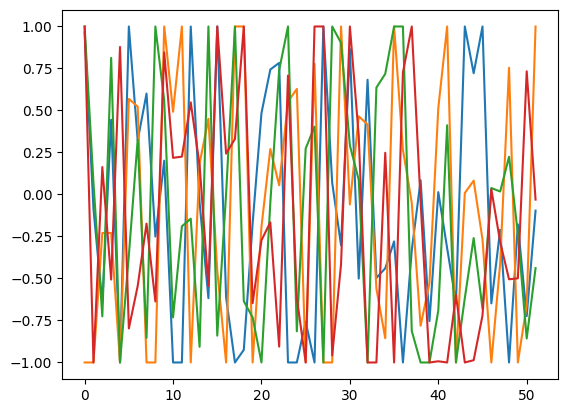

In [39]:
# plot action list
import matplotlib.pyplot as plt
action_list = np.array(action_list)
plt.plot(action_list)
